In [ ]:
#!pip install transformers

In [ ]:
import torch
from transformers import GPTNeoForCausalLM, GPT2Tokenizer, Trainer
from torch.utils.data import random_split

model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125m").cuda()

tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125m",
                            bos="<BOS>",
                            mid="<MID>",
                            eos="<EOS>",
                            pad="<PAD>")
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

In [34]:

import pandas as pd

df = pd.read_csv("reddit_scrape_20_cleansed.csv")
#print(df)
# Remove NaN values
df = df.dropna()

# Create a boolean mask for rows to keep
# Text contains "&amp;#x200B;" which is a zero-width space (tokenized incorrectly)
mask = ~(
    df['title'].str.contains('x200B|&amp;#x200B;', na=False) |
    df['selftext'].str.contains('x200B|&amp;#x200B;', na=False)
)

# Apply the mask to filter the DataFrame
df = df[mask]

# Remove all entries greater than 50 tokens
cut_off = 50
token_lengths_title = df['title'].apply(lambda x: len(x.split()))
token_lengths_selftext = df['selftext'].apply(lambda x: len(x.split()))
df = df[(token_lengths_title < cut_off) & (token_lengths_selftext < cut_off)]

first = df["title"].tolist()
second = df["selftext"].tolist()
score = df["score"].tolist()

sentences= list(zip(first, second))
max_length = 50


In [46]:
print(len(sentences))
sentences=[]

for i in range(len(score)):
  if score[i]>=40:
    sentences.append((first[i], second[i]))

import numpy as np
array= np.random.randint(0, 59036, size=2)

print(array)
print(sentences[array[0]])
print(sentences[array[1]])

59036
[2433 5311]
('I ate my sister in the womb.', 'Too bad for mom I was seven at the time.')
('“You’re so sweet”, I told my wife as she started to rub my back.', '“What’d you say?” She shouted from the other room.')


In [ ]:
class TwoSentenceDataset:
    def __init__(self, txt_list, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for i in range(len(txt_list)):
            encodings_dict = tokenizer("<BOS>" + txt_list[i][0] + "<MID>" + txt_list[i][1]  + "<EOS>", truncation=True, max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict["input_ids"]) )
            self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
from torch import nn

In [ ]:
dataset = TwoSentenceDataset(sentences, tokenizer, max_length)

In [ ]:
dataset.__len__()

59036

In [ ]:
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = random_split(dataset,
                            [train_size, len(dataset) - train_size])

In [ ]:
from transformers import TrainingArguments

In [ ]:
!pip install -U accelerate
!pip install -U transformers

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.25.0')

In [ ]:
trainingArg = TrainingArguments(num_train_epochs=4,
                                  logging_steps=5000,
                                  save_steps=5000,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  warmup_steps=100,
                                  weight_decay=0.01,)

In [ ]:
trainer = Trainer(model=model, args=trainingArg,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  data_collator=lambda data:
              {"input_ids": torch.stack([f[0] for f in data]),
               "attention_mask": torch.stack([f[1] for f in data]),
               "labels": torch.stack([f[0] for f in data])})
trainer.train()


Step,Training Loss
5000,2.690800
10000,2.600800
15000,2.486800
20000,2.343200
25000,2.362100
30000,2.206900
35000,2.152700
40000,2.159500
45000,1.990300
50000,1.993200


TrainOutput(global_step=53132, training_loss=2.280622987029944, metrics={'train_runtime': 2823.0567, 'train_samples_per_second': 75.283, 'train_steps_per_second': 18.821, 'total_flos': 5421271678156800.0, 'train_loss': 2.280622987029944, 'epoch': 4.0})

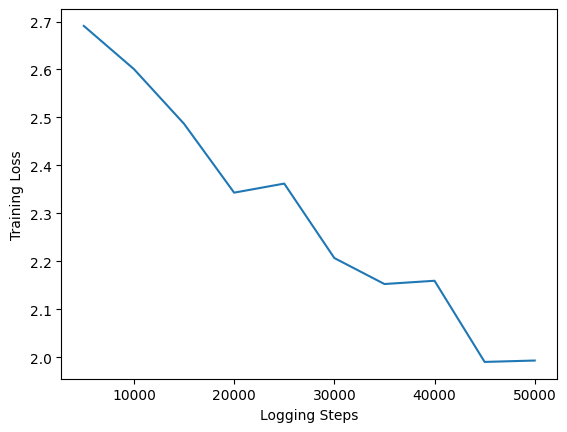

In [28]:
import matplotlib.pyplot as plt
x=[5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
y=[2.690800, 2.600800, 2.486800, 2.343200, 2.362100, 2.206900, 2.152700, 2.159500, 1.990300, 1.993200]
plt.plot(x,y)
plt.xlabel("Logging Steps")
plt.ylabel("Training Loss")
plt.show()

In [57]:
generated = tokenizer("<BOS> ", return_tensors="pt").input_ids.cuda()
outputs = model.generate(generated,
                 do_sample=True,
                 max_length=max_length,
                 num_return_sequences=5)
for i, output in enumerate(outputs):
    print(f"{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:    

There is a reason why I'm stuck in a room with the mirror.<MID>But he's the one who made it look.
1:    while walking to school, my classmates exclaimed "Oh god, they're screaming!" <MID>That's when I realized I should have locked my phone...
2:       

The child cried from yet another empty room, unable to scream.<MID>      

He opened the door and realized that, after all, his father was in the living
3:                                                  
4:    

She put her hands around my beautiful body and whispered "Honey let's get the shower ready!"<MID>I felt the shower drain for just seconds and the water didn't make sense.
